<a href="https://colab.research.google.com/github/Komsomolochka/stats-for-data-analysis/blob/main/forecast/forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from scipy import stats
from itertools import product
import warnings

In [2]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [3]:
data = pd.read_csv('/content/WAG_C_M.csv', sep=';', parse_dates=['month'], dayfirst=True, index_col=['month'])

In [4]:
data

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5
...,...
2016-04-01,36497.0
2016-05-01,37270.0
2016-06-01,38447.0


#1. Визуальный анализ ряда

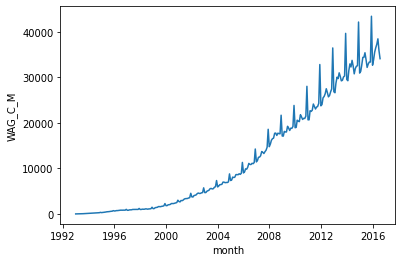

In [5]:
sns.lineplot(data=data, x="month", y="WAG_C_M")

*По графику можно сделать выводы:*

* *годовая сезонность*
* *возрастающая линия тренда*
* *нестационарная дисперсия (размах увеличивается)*
* *ряд нестационарен*



*Проверим стационарность и проведем STL-декомпозицию ряда*

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Критерий Дики-Фуллера: p=0.991850


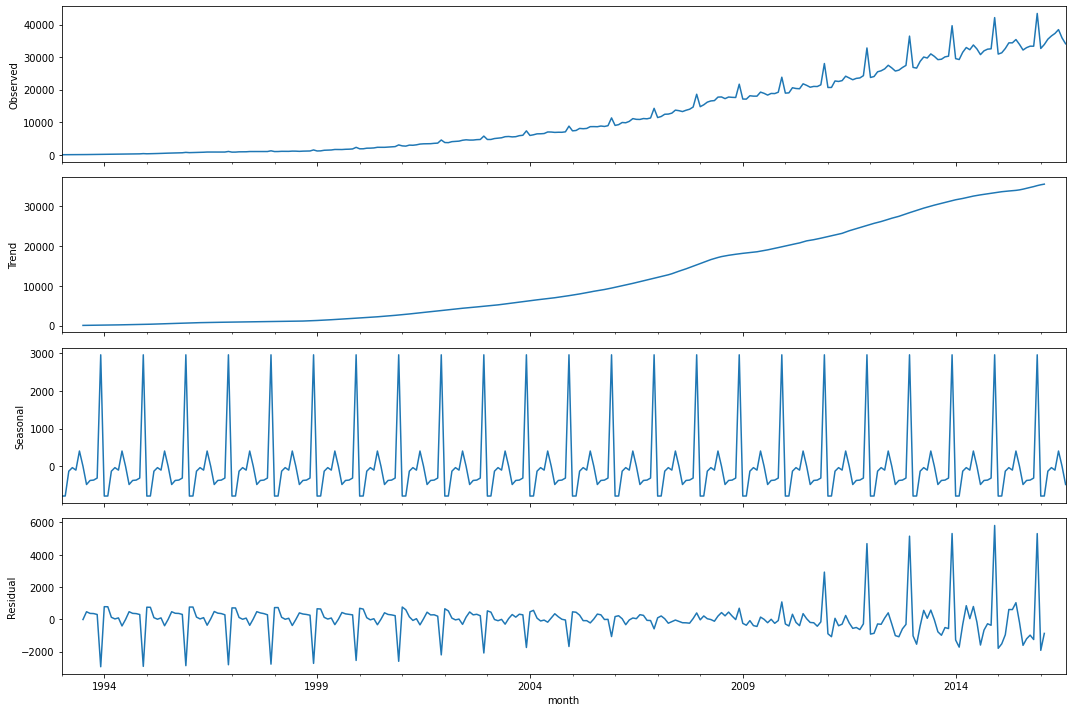

In [6]:
%pylab
figsize(15,10)
sm.tsa.seasonal_decompose(data['WAG_C_M']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['WAG_C_M'])[1])

*На графиках хорошо видно возрастающий тренд, сезонную составляющую и некоторую автокоррелированность остатков.*

*Критерий Дики-Фуллера >0,05. Гипотеза о стационарности не отвергается, но тем не менее по графикам мы видим, что ряд нестационарен.*

# 2. Стабилизация дисперсии

*Для стабилизации дисперсии применяем преобразование Бокса-Кокса, посторим STL-декомпозицию и проверим стационарность*

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


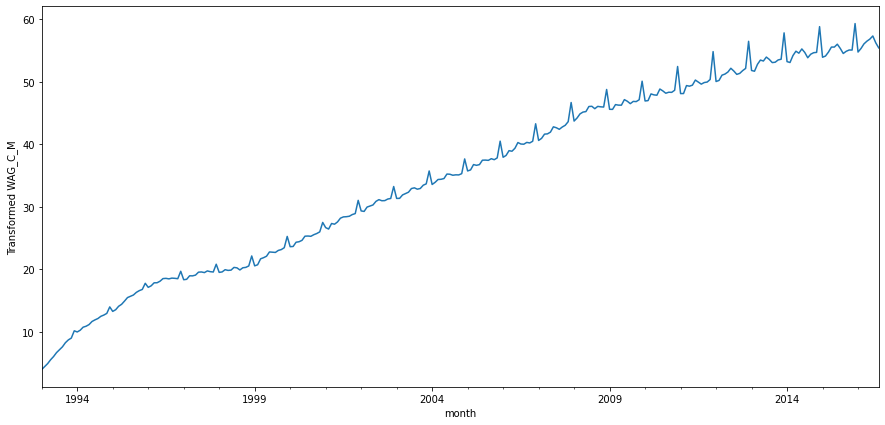

In [7]:
data['WAG_C_M_box'], lmbda = stats.boxcox(data['WAG_C_M'])
plt.figure(figsize(15,7))
data['WAG_C_M_box'].plot()
plt.ylabel(u'Transformed WAG_C_M')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['WAG_C_M_box'])[1])

*Преобразования недостаточно, пробуем сезонное дифференцирование*

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

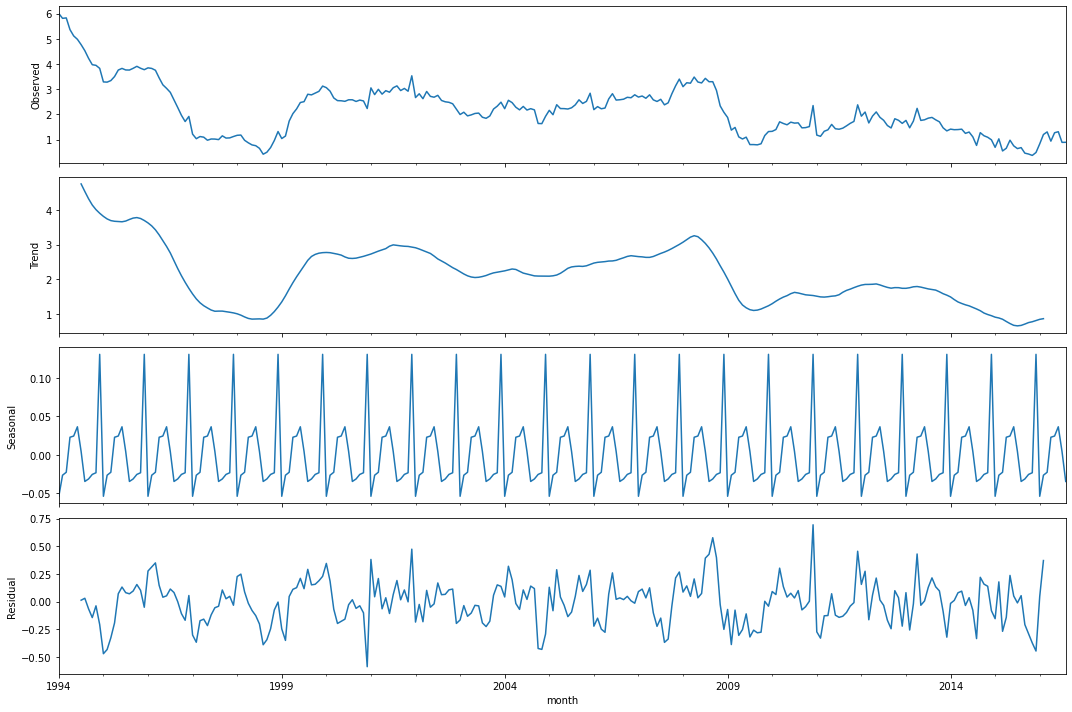

In [8]:
data['WAG_C_M_diff'] = data['WAG_C_M_box'] - data['WAG_C_M_box'].shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data['WAG_C_M_diff'][12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['WAG_C_M_diff'][12:])[1])

*Стало лучше, тренд ушел, пробуем избавиться от сезонности*

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

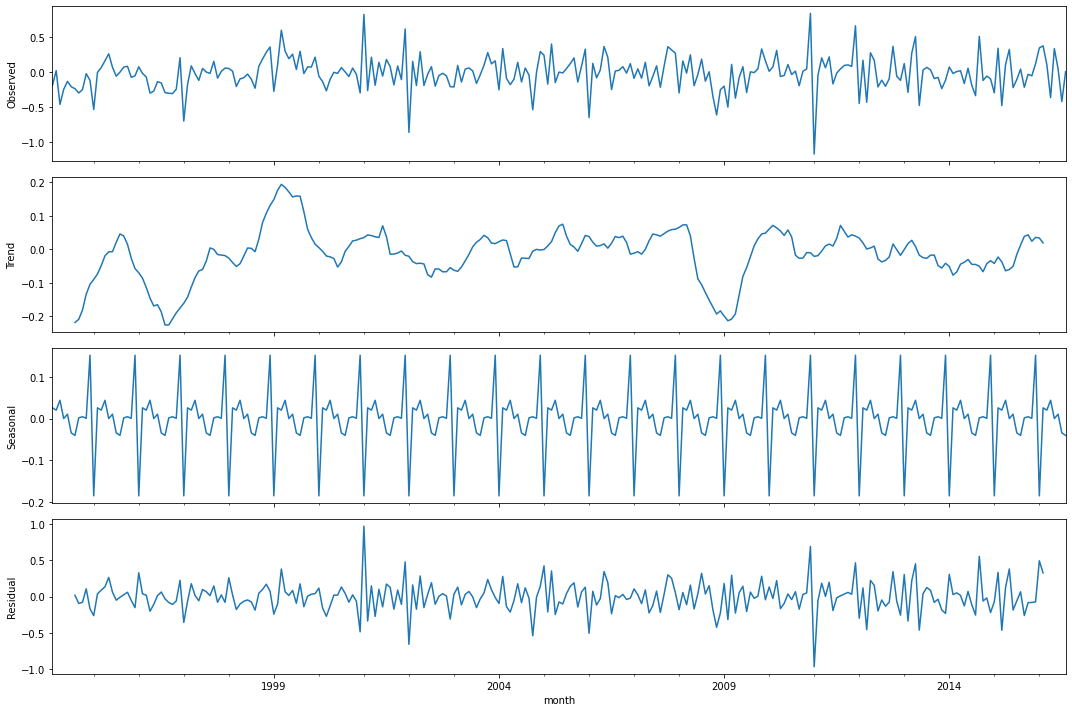

In [9]:
data['WAG_C_M_diff2'] = data['WAG_C_M_diff'] - data['WAG_C_M_diff'].shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data['WAG_C_M_diff2'][13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['WAG_C_M_diff2'][13:])[1])

*Критерий Дики-Фуллера <0.05, гипотезу о нестационарности отвергаем*

# 3. Выбор начальных приближений для p, q, P, Q

*Строим графики ACF и PACF*

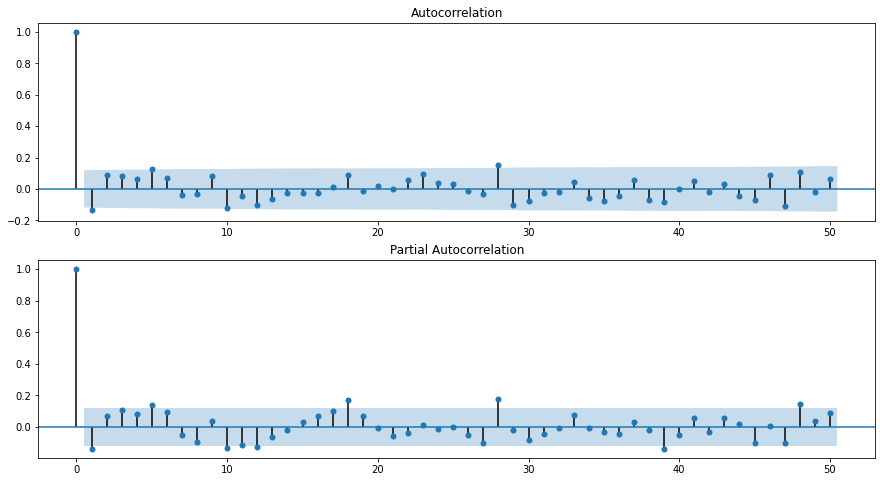

In [10]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['WAG_C_M_diff2'][13:].values.squeeze(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['WAG_C_M_diff2'][13:].values.squeeze(), lags=50, ax=ax)
pylab.show()

*Начальные приближения: Q=0, q=1, P=4, p=1*

#5. Обучение и сравнение моделей-кандидатов, выбор победителя

In [16]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

In [19]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

20

In [20]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data['WAG_C_M_box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 45.4 s, sys: 32.3 s, total: 1min 17s
Wall time: 40.1 s


In [21]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
11  (1, 0, 1, 0)  0.340521
6   (0, 1, 1, 0)  1.170768
12  (1, 0, 2, 0)  1.622924
16  (1, 1, 1, 0)  2.021911
7   (0, 1, 2, 0)  2.509650


*Лучшая модель*

In [22]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Thu, 20 Jan 2022   AIC                              0.341
Time:                                    16:04:32   BIC                             11.147
Sample:                                01-01-1993   HQIC                             4.679
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

*Проверим остатки*

Критерий Стьюдента: p=0.090798
Критерий Дики-Фуллера: p=0.000003


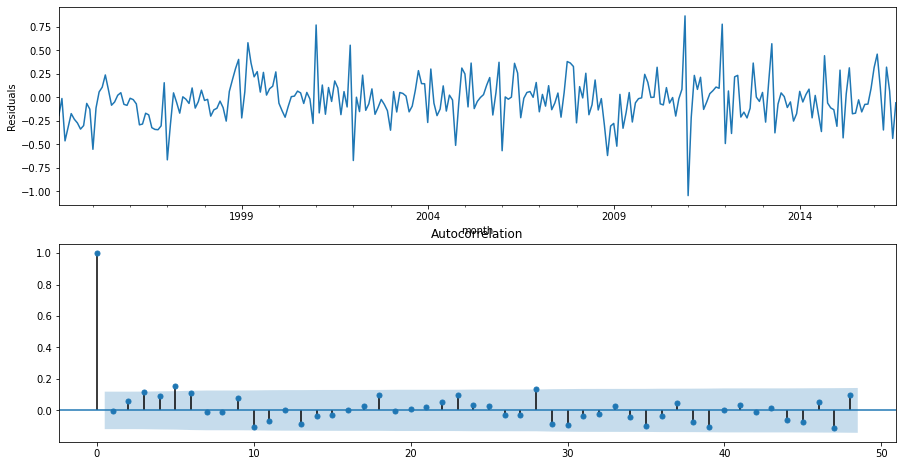

In [23]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

#6. Анализ остатков построенной модели, при необходимости — её модификация: 
если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p, q, P, Qp,q,P,Q.


*Остатки:*
* *несмещены - критерий Стьюдента*
* *стационарны - критерий Дики-Фуллера*
* *неавтокоррелированы - критерий Льюнга-Бокса*


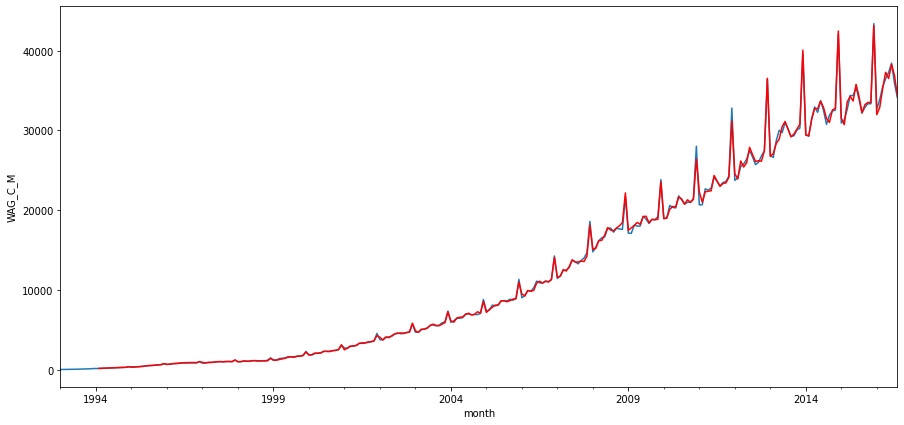

In [24]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data['WAG_C_M'].plot()
data['model'][13:].plot(color='r')
plt.ylabel('WAG_C_M')
pylab.show()

# 7. Прогнозирование с помощью финальной модели.

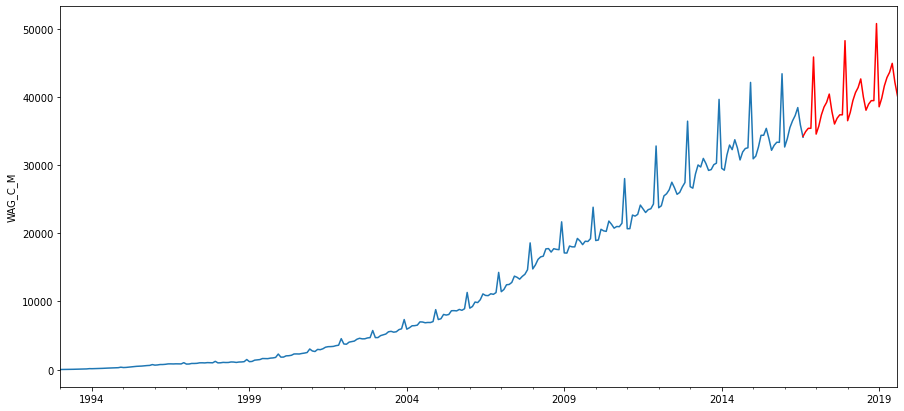

In [38]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=283, end=319), lmbda)

plt.figure(figsize(15,7))
data2['WAG_C_M'].plot()
data2['forecast'].plot(color='r')
plt.ylabel('WAG_C_M')
pylab.show()